In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils.utils import load_config
from datasets.SyntheticData import SyntheticData
import numpy as np
import pandas as pd
from torch_geometric.utils import to_dense_adj
import os

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


## two-step-SINDy

In [4]:
from models.baseline.TSS.NumericalDerivatives import NumericalDeriv
from models.baseline.TSS.ElementaryFunctions_Matrix import ElementaryFunctions_Matrix
from models.baseline.TSS.TwoPhaseInference import TwoPhaseInference

## Utils

In [5]:
def load_data_tss(config, snr_db = -1):
    dataset = SyntheticData(
        root=config['data_folder'],
        dynamics=config['name'],
        t_span=config['t_span'],
        t_max=config['t_eval_steps'],
        num_samples=config['num_samples'],
        seed=config['seed'],
        n_ics=config['n_iter'],
        input_range=config['input_range'],
        device=config['device'],
        horizon = config['horizon'],
        history = config['history'],
        stride=config.get('stride', 5),
        predict_deriv=config.get("predict_deriv", False),
        snr_db=snr_db,
        **config['integration_kwargs']
    )
    
    raw_data = dataset.raw_data_sampled.cpu().detach().numpy() # shape: (ics, time_steps, n_nodes, 1)
    time = dataset.t_sampled
    
    edge_index = dataset[0].edge_index
    A = to_dense_adj(edge_index)[0].cpu().detach().numpy()
    
    return raw_data, A, time


def get_matrix_tss(raw_data, time, A, Dim=1, selfPolyOrder = 3, act_index=False):
    dt = time[0, 1] - time[0, 0]
    dt = dt.item()
    Nnodes = A.shape[0]
    
    data = []
    num_deriv = []
    Matrix = []
    
    for ic in range(raw_data.shape[0]):
        data_ic = raw_data[ic].squeeze(-1)  # shape: (time_steps, n_nodes)
        num_deriv_ic = NumericalDeriv(
            TimeSeries=data_ic,
            dim=1,
            Nnodes=data_ic.shape[1],
            deltT=dt
        )   # pd DatafRame
        
        data_ic = data_ic[2:-2,:]
        data.append(data_ic)
        num_deriv.append(num_deriv_ic)
        matrix_ic = ElementaryFunctions_Matrix(
            data_ic, 
            Dim, 
            Nnodes, 
            A, 
            selfPolyOrder, 
            coupledPolyOrder = 1, 
            PolynomialIndex = True, 
            TrigonometricIndex = True, 
            ExponentialIndex = True, 
            FractionalIndex = True, 
            ActivationIndex = act_index, 
            RescalingIndex = False, 
            CoupledPolynomialIndex = True,
            CoupledTrigonometricIndex = True, 
            CoupledExponentialIndex = True, 
            CoupledFractionalIndex = True,
            CoupledActivationIndex = act_index, 
            CoupledRescalingIndex = False
        )
        
        Matrix.append(matrix_ic)
        

    data = np.concatenate(data, axis=0)
    num_deriv = pd.concat(num_deriv, ignore_index=True)
    Matrix = pd.concat(Matrix, ignore_index=True)
    Matrix = Matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
    
    return Matrix, num_deriv, data


def two_step_sindy(Matrix, num_deriv, Nnodes, out_path, Dim = 1, plotstart = 0.5, plotend = 0.9, Keep = 10, SampleTimes = 20, Batchsize = 1,
                   snr_db = -1):
    Lambda = pd.DataFrame([[0.01, 0.5, 1]])
    os.makedirs(out_path, exist_ok=True)
    
    for dim in range(Dim):
        InferredResults, _, _, _ = TwoPhaseInference(
            Matrix, 
            num_deriv, 
            Nnodes, 
            dim, 
            Dim, 
            Keep, 
            SampleTimes,
            Batchsize, 
            Lambda, 
            plotstart, 
            plotend
        )
        
        save_file = f"{out_path}/results_dim={dim}.csv" if snr_db < 0 else f"{out_path}/results_dim={dim}_{snr_db}_db.csv"
        InferredResults.to_csv(save_file)
    
    
        

## Two Phase Inference

In [ ]:
# config_path = 'configs/config_pred_deriv/config_ic1/config_biochemical.yml'
# conf = load_config(config_path)
# conf['n_iter'] = 1
# conf['t_eval_steps'] = 20000
# conf['data_folder'] = './data_tmp'

# raw_data, A, time = load_data_tss(conf)

# Matrix, num_deriv, _ = get_matrix_tss(
#     raw_data=raw_data,
#     time = time,
#     A=A,
#     Dim=1,
#     selfPolyOrder=1
# )

# two_step_sindy(
#     Matrix=Matrix,
#     num_deriv=num_deriv,
#     Nnodes=A.shape[0],
#     out_path=f'./saved_models_optuna/tss/{conf['name']}-{conf['n_iter']}'
# )

0.9999875395443762
Best threshold: 0.001
Elementary functions discovered by Phase 1 without constant.
x1ix1j           -4.992071e-01
x1               -4.629238e-01
tanx1            -1.882994e-02
sinx1ix1j        -3.248205e-04
x1isinx1j        -2.287443e-04
expx1j            1.000000e-10
x1iexpx1j         1.000000e-10
expx1ix1j         1.000000e-10
sinx1jMinusx1i    1.018141e-04
x1jMinusx1i       5.803586e-04
dtype: float64
Elementary functions discovered by Phase 1 with constant.
x1ix1j           -4.992071e-01
x1               -4.629238e-01
tanx1            -1.882994e-02
sinx1ix1j        -3.248205e-04
x1isinx1j        -2.287443e-04
x1iexpx1j         1.000000e-10
expx1ix1j         1.000000e-10
sinx1jMinusx1i    1.018141e-04
x1jMinusx1i       5.803586e-04
constant          9.914368e-01
dtype: float64
-1417952.2121795572 -708839.2301855906 -1624295.0632193047
1.0 0.499903469310875 1.145521724404643
This equation may contain a constant term.
Index(['x1ix1j', 'x1', 'tanx1', 'sinx1ix1j', 'x1

### Clean data

In [5]:
configs = [
    'configs/config_pred_deriv/config_ic1/config_kuramoto.yml',
    'configs/config_pred_deriv/config_ic1/config_biochemical.yml',
    'configs/config_pred_deriv/config_ic1/config_epidemics.yml',
    'configs/config_pred_deriv/config_ic1/config_population.yml'
]

for conf_path in configs:
    conf= load_config(config_path=conf_path)
    raw_data, A, time = load_data_tss(conf)
    
    Matrix, num_deriv, _ = get_matrix_tss(
        raw_data=raw_data,
        time = time,
        A=A,
        Dim=1,
        selfPolyOrder=3
    )
    
    two_step_sindy(
        Matrix=Matrix,
        num_deriv=num_deriv,
        Nnodes=A.shape[0],
        out_path=f'./saved_models_optuna/tss/{conf['name']}-{conf['n_iter']}'
    )

0.9999980944046324
Best threshold: 0.001
Elementary functions discovered by Phase 1 without constant.
expx1jMinusx1i    -2.426559e-07
x1                 1.000000e-10
x1x1x1             1.000000e-10
x1x1               1.000000e-10
cosx1              1.000000e-10
x1iexpx1j          1.000000e-10
fracx1j            1.000000e-10
x1ifracx1j         1.000000e-10
fracx1jMinusx1i    1.000000e-10
sinx1jMinusx1i     4.993043e-01
dtype: float64
Elementary functions discovered by Phase 1 with constant.
expx1jMinusx1i    -2.426559e-07
x1                 1.000000e-10
x1x1x1             1.000000e-10
x1x1               1.000000e-10
cosx1              1.000000e-10
fracx1j            1.000000e-10
x1ifracx1j         1.000000e-10
fracx1jMinusx1i    1.000000e-10
sinx1jMinusx1i     4.993043e-01
constant           2.000026e+00
dtype: float64
-10448.293151657102 13736.321661095055 -10450.293151657102
1.0 -1.3146952771818496 1.0001914188251584
Index(['expx1jMinusx1i', 'x1', 'x1x1x1', 'x1x1', 'cosx1', 'fracx1j',

### Noise

In [6]:
configs = [
    'configs/config_pred_deriv/config_ic1/config_kuramoto.yml',
    'configs/config_pred_deriv/config_ic1/config_biochemical.yml',
    'configs/config_pred_deriv/config_ic1/config_epidemics.yml',
    'configs/config_pred_deriv/config_ic1/config_population.yml'
]

snr_db_levels = [70, 50, 20]

for conf_path in configs:
    for snr_db in snr_db_levels:
        
        conf = load_config(config_path=conf_path)
        raw_data, A, time = load_data_tss(conf, snr_db=snr_db)
        
        Matrix, num_deriv, _ = get_matrix_tss(
            raw_data=raw_data,
            time = time,
            A=A,
            Dim=1,
            selfPolyOrder=3
        )
        
        two_step_sindy(
            Matrix=Matrix,
            num_deriv=num_deriv,
            Nnodes=A.shape[0],
            out_path=f'./saved_models_optuna/tss/{conf['name']}-{conf['n_iter']}',
            snr_db=snr_db
        )

0.07140022547244496
Best threshold: 0.001
Elementary functions discovered by Phase 1 without constant.
expx1jMinusx1i    -7.166574e-07
expx1ix1j          1.000000e-10
x1                 1.000000e-10
x1x1               1.000000e-10
cosx1              1.000000e-10
x1iexpx1j          1.000000e-10
fracx1j            1.000000e-10
fracx1jMinusx1i    5.235118e-06
tanx1              5.764568e-06
sinx1jMinusx1i     4.991748e-01
dtype: float64
Elementary functions discovered by Phase 1 with constant.
expx1jMinusx1i    -7.166574e-07
expx1ix1j          1.000000e-10
x1                 1.000000e-10
x1x1               1.000000e-10
cosx1              1.000000e-10
fracx1j            1.000000e-10
fracx1jMinusx1i    5.235118e-06
tanx1              5.764568e-06
sinx1jMinusx1i     4.991748e-01
constant           2.000210e+00
dtype: float64
42992.520849586916 48287.17509309217 42990.520849586916
1.0 1.123152914480848 0.9999534802807447
This equation may contain a constant term.
Index(['expx1jMinusx1i', 'exp

## Real Epid data

In [13]:
from datasets.RealEpidemics import RealEpidemics

real_epid_data = RealEpidemics(
    root = './data_real_epid_covid_scaled',
    name = 'RealEpid',
    predict_deriv=True,
    scale=True,
    scale_range=(-1, 1),
    train_perc=0.8
)

Processing...
Done!


Building the dataset...


In [14]:
import json

with open('./data_real_epid_covid_scaled/RealEpid/countries_dict.json', 'r') as f:
    countries_dict = json.load(f)

In [15]:
covid_ts = real_epid_data.raw_data_sampled[0].detach().cpu().numpy()

In [16]:
import matplotlib.pyplot as plt

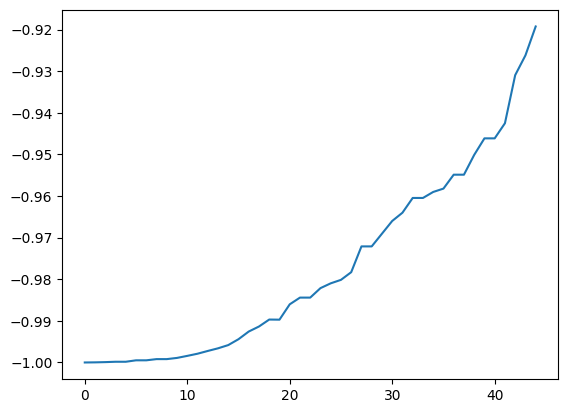

In [17]:
plt.plot(covid_ts[:, countries_dict['Canada'], :])

In [19]:
raw_data = real_epid_data.raw_data_sampled.cpu().detach().numpy() # shape: (ics, time_steps, n_nodes, 1)
time = real_epid_data.t_sampled

edge_index = real_epid_data[0].edge_index
A = to_dense_adj(edge_index)[0].cpu().detach().numpy()

Matrix, num_deriv, _ = get_matrix_tss(
    raw_data=raw_data,
    time = time,
    A=A,
    Dim=1,
    selfPolyOrder=3,
    act_index=True
)

two_step_sindy(
    Matrix=Matrix,
    num_deriv=num_deriv,
    Nnodes=A.shape[0],
    out_path=f'./saved_models_optuna/tss/real_epid_covid_scaled'
)

0.7749047641749812
Best threshold: 0.881
Elementary functions discovered by Phase 1 without constant.
sig_x1_105             -1.217782e+12
sinx1jMinusx1i         -6.571687e-02
x1                      1.000000e-10
x1x1                    1.000000e-10
cosx1                   1.000000e-10
x1itanhx1j              1.000000e-10
tanhx1ix1j              1.000000e-10
regx1jMinusx1igamma2    1.816518e-02
sigx1jalpha10beta1      6.895311e-02
sig_x1_100              1.782914e+00
dtype: float64
Elementary functions discovered by Phase 1 with constant.
sig_x1_105             -1.217782e+12
sinx1jMinusx1i         -6.571687e-02
x1                      1.000000e-10
x1x1                    1.000000e-10
cosx1                   1.000000e-10
tanhx1ix1j              1.000000e-10
regx1jMinusx1igamma2    1.816518e-02
sigx1jalpha10beta1      6.895311e-02
sig_x1_100              1.782914e+00
constant                1.306626e-01
dtype: float64
-2589.6808569136115 -2526.3342512569843 -2591.3095352458054
1.0 0.9755